In [1]:
import pickle
import datetime

In [2]:
naver_article = pd.read_csv("data/raw/네이버기사/naver_article.csv")
suicide_count_2015 = pd.read_csv("data/raw/자살자수/2015.csv", header=None, names=["사망자 주소(시도)", "성별", "사망연월일", "사망시간", "사망원인 56항목 분류"])
suicide_count_2016 = pd.read_csv("data/raw/자살자수/2016.csv", header=None, names=["사망자 주소(시도)", "성별", "사망연월일", "사망시간", "사망원인 56항목 분류"])
suicide_count_2017 = pd.read_csv("data/raw/자살자수/2017.csv", header=None, names=["사망자 주소(시도)", "성별", "사망연월일", "사망시간", "사망원인 56항목 분류"])
population = pd.read_csv("data/raw/총인구수/인구총조사_인구_시도_시_군_구(2015-2017)__20190802230502.csv", encoding="euc-kr")

### Naver Article

In [3]:
naver_article.head()

,category,content,date,link,photo_url,press,title
0,세계,사우디아라비아 북서부 국경지대에서 자살폭탄 테러와 총격을 가한 일당 4명 중 3명이...,2015-01-10 16:40:00,https://news.naver.com/main/read.nhn?mode=LSD&...,NaN,SBS(text),사우디군 겨냥 자폭테러는 자국민 소행
1,사회,(서산=뉴스1) 김종익 기자 = 충청남도 서산의료원에 근무하는 A씨(37)가 지난 ...,2015-01-10 23:04:00,https://news.naver.com/main/read.nhn?mode=LSD&...,NaN,뉴스1,행방 감춘 서산의료원 30대 직원 숨진채 발견
2,세계,(두바이=연합뉴스) 강훈상 특파원 = 5일(현지시간) 사우디아라비아 북서부 국경지대...,2015-01-10 14:50:00,https://news.naver.com/main/read.nhn?mode=LSD&...,NaN,연합뉴스,사우디군 겨냥 자폭테러는 자국민 소행
3,정치,[앵커] 초유의 항명사태를 짚어보겠습니다. 청와대가 정윤회 문건 사건과 관련해서...,2015-01-10 16:50:00,https://news.naver.com/main/read.nhn?mode=LSD&...,NaN,YTN,靑 민정수석 초유의 '항명사태'
4,세계,(이스탄불=연합뉴스) 김준억 특파원 = 터키 이스탄불의 쇼핑몰 두 곳에서 10일(현...,2015-01-10 20:08:00,https://news.naver.com/main/read.nhn?mode=LSD&...,NaN,연합뉴스,터키 이스탄불 쇼핑몰 2곳 사제폭발물 발견


In [4]:
naver_article["date"] = naver_article["date"].astype("datetime64")
naver_article["merge_date"] = naver_article["date"].apply(lambda x : x.date())

In [5]:
## 중복 기사 제거
print("중복 기사 제거 이전: {}개".format(len(naver_article)))
naver_article = naver_article.drop_duplicates(['content'], keep='first')
print("중복 기사 제거 이후: {}개".format(len(naver_article)))

중복 기사 제거 이전: 120379개
중복 기사 제거 이후: 112369개


### 자살자 수

In [6]:
suicide_count = pd.concat([suicide_count_2015, suicide_count_2016, suicide_count_2017], ignore_index=True)

In [7]:
## 혹시 몰라서 만들어놓은 자살시각
suicide_count["사망연월일"] = suicide_count["사망연월일"].apply(lambda x : datetime.datetime.strptime(str(x), "%Y%m%d"))
suicide_count["사망시간"] = suicide_count["사망시간"].apply(
    lambda x : datetime.timedelta(hours=x) if x == 99 else datetime.timedelta(hours=x))
suicide_count["time"] = suicide_count["사망연월일"] + suicide_count["사망시간"]

In [8]:
## 필요한 데이터 만들기
suicide_count = suicide_count.groupby("사망연월일").count().iloc[:, 1].reset_index()
suicide_count.columns = ["date", "count"]

In [9]:
suicide_count.head()

,date,count
0,2015-01-01,35
1,2015-01-02,35
2,2015-01-03,33
3,2015-01-04,31
4,2015-01-05,30


### 대한민국 총 인구
- 대한민국 총 인구수는 매년 11월 1일 기준.
- 데이터 보간(interpolation)으로 일자별 인구수 추정
- reference: https://datascienceschool.net/view-notebook/288492be71084c2991bf0a4087355e0f/

In [10]:
population_year = population.loc[0, ["2015", "2016", "2017"]].reset_index()
population_year.columns = ["date", "count"]
population_year["date"] = ["2015-11-01", "2016-11-01", "2017-11-01"]
population_year["date"] = population_year["date"].astype("datetime64")

In [11]:
population_year

,date,count
0,2015-11-01,51069375
1,2016-11-01,51269554
2,2017-11-01,51422507


In [12]:
## 총 인구수 데이터 보간
import scipy.interpolate as spi
ipo = spi.splrep(population_year["date"].apply(datetime.datetime.toordinal), population_year["count"], k=1)
date = pd.date_range(start='20150101', end='20171231').map(datetime.datetime.toordinal)
population_interpolation = list(map(int, spi.splev(date, ipo)))
population_date = pd.DataFrame({"date" : pd.date_range(start='20150101', end='20171231'), "population" : population_interpolation})
population_date.head()

,date,population
0,2015-01-01,50903106
1,2015-01-02,50903653
2,2015-01-03,50904199
3,2015-01-04,50904746
4,2015-01-05,50905293


### 10만명 당 자살율 계산

In [13]:
suicide_rate = pd.DataFrame()
suicide_rate["merge_date"] = population_date["date"]
suicide_rate["suicide_rate"] = 100000*suicide_count["count"] / population_date["population"]
suicide_rate.head()

,merge_date,suicide_rate
0,2015-01-01,0.068758
1,2015-01-02,0.068757
2,2015-01-03,0.064828
3,2015-01-04,0.060898
4,2015-01-05,0.058933


In [14]:
## merge_date 
suicide_rate["merge_date"] = suicide_rate["merge_date"].apply(lambda x : x.date())

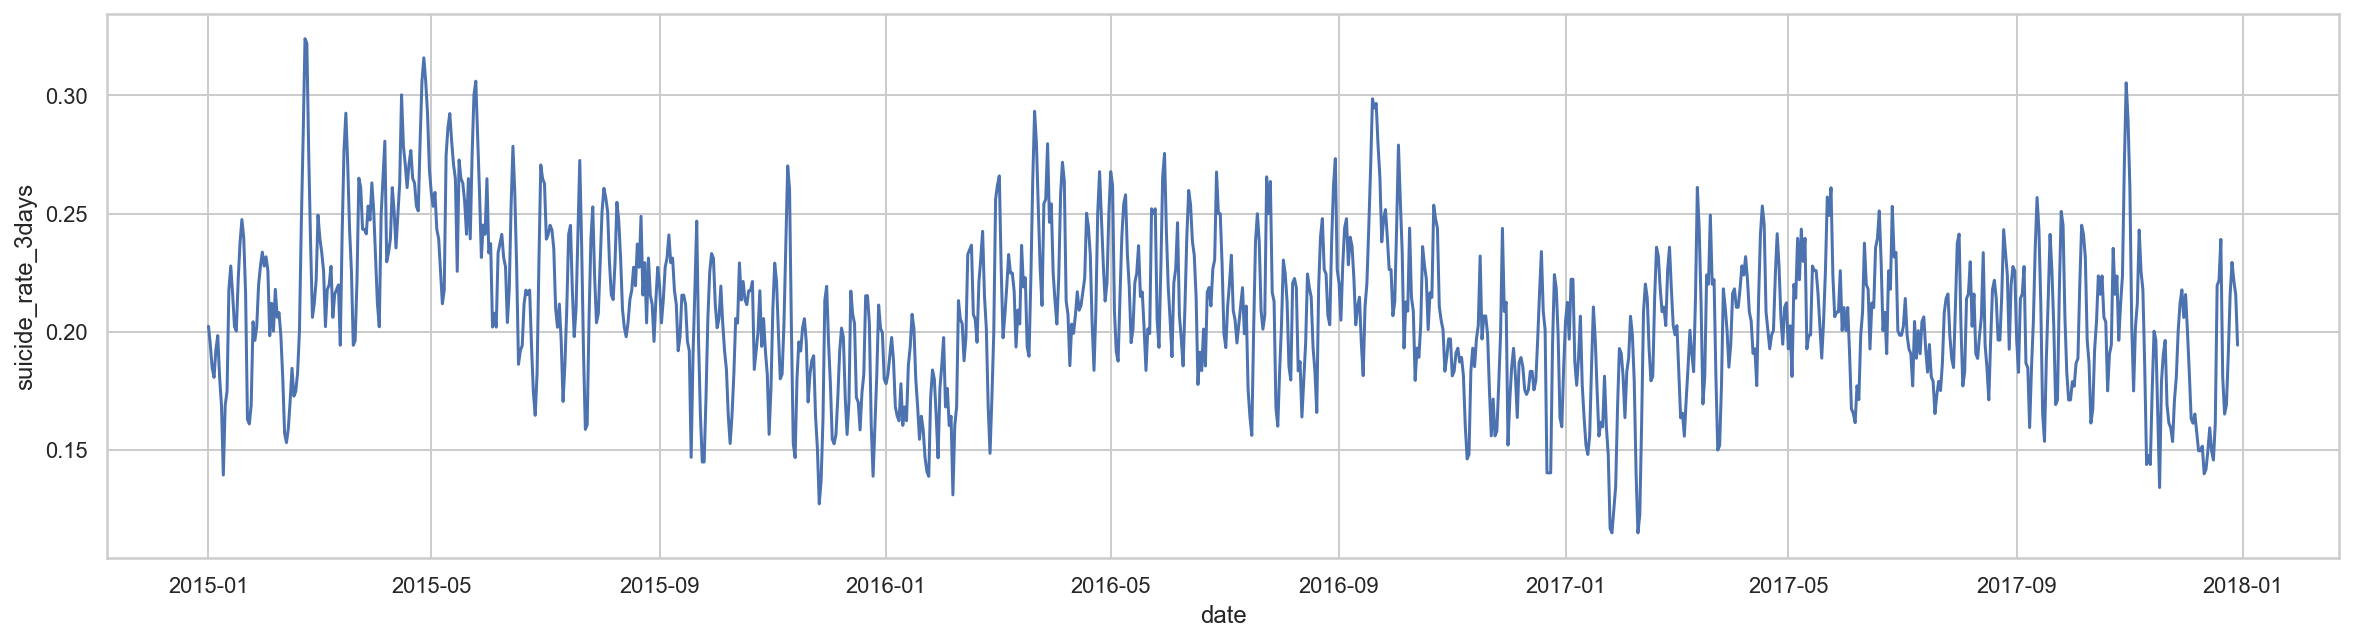

In [15]:
## 심심해서 그려본 3일동안 자살율
sc = suicide_rate.copy()
sc.index = sc.merge_date
sc["rate_3days"] = None

for idx in range(len(sc)-2):
    sc.iloc[idx, 2] = sc.iloc[idx:idx+3, 1].sum()
    
plt.figure(figsize = (20, 5))
plt.plot(sc.index, sc["rate_3days"])
plt.xlabel("date")
plt.ylabel("suicide_rate_3days")
plt.show()

### data merge

In [18]:
df = pd.merge(naver_article, suicide_rate, on="merge_date")
df.drop(columns = ["merge_date"], inplace = True)
len(df)

92549

In [19]:
df.head()

,category,content,date,link,photo_url,press,title,suicide_rate
0,세계,사우디아라비아 북서부 국경지대에서 자살폭탄 테러와 총격을 가한 일당 4명 중 3명이...,2015-01-10 16:40:00,https://news.naver.com/main/read.nhn?mode=LSD&...,NaN,SBS(text),사우디군 겨냥 자폭테러는 자국민 소행,0.060894
1,사회,(서산=뉴스1) 김종익 기자 = 충청남도 서산의료원에 근무하는 A씨(37)가 지난 ...,2015-01-10 23:04:00,https://news.naver.com/main/read.nhn?mode=LSD&...,NaN,뉴스1,행방 감춘 서산의료원 30대 직원 숨진채 발견,0.060894
2,세계,(두바이=연합뉴스) 강훈상 특파원 = 5일(현지시간) 사우디아라비아 북서부 국경지대...,2015-01-10 14:50:00,https://news.naver.com/main/read.nhn?mode=LSD&...,NaN,연합뉴스,사우디군 겨냥 자폭테러는 자국민 소행,0.060894
3,정치,[앵커] 초유의 항명사태를 짚어보겠습니다. 청와대가 정윤회 문건 사건과 관련해서...,2015-01-10 16:50:00,https://news.naver.com/main/read.nhn?mode=LSD&...,NaN,YTN,靑 민정수석 초유의 '항명사태',0.060894
4,세계,(이스탄불=연합뉴스) 김준억 특파원 = 터키 이스탄불의 쇼핑몰 두 곳에서 10일(현...,2015-01-10 20:08:00,https://news.naver.com/main/read.nhn?mode=LSD&...,NaN,연합뉴스,터키 이스탄불 쇼핑몰 2곳 사제폭발물 발견,0.060894


In [20]:
with open("data/use/df.pkl", "wb") as f:
    pickle.dump(df, f)